In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, random_split
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import numpy as np

In [2]:
# CONFIG
DATA_DIR = "Train"
VAL_DIR = "Validation"
WEIGHTS_PATH = "xray_model.pt"
OUTPUT_CSV = "validation_results.csv"
LOSS_PLOT_PATH = "loss_accuracy_plot.png"
BATCH_SIZE = 32
NUM_CLASSES = 3
EPOCHS = 60
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# LABELS
LABEL_MAP = {"FRONTAL": 0, "LATERAL": 1, "TRASH": 2}
INV_LABEL_MAP = {v: k.lower() for k, v in LABEL_MAP.items()}

# TRANSFORMS
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [3]:
# CUSTOM DATASET
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, label_map, transform):
        self.samples = []
        self.transform = transform
        for label_name, label_idx in label_map.items():
            folder = os.path.join(root_dir, label_name)
            for fname in os.listdir(folder):
                if not fname.lower().endswith((".png", ".jpg", ".jpeg")):
                    continue
                self.samples.append((os.path.join(folder, fname), label_idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = Image.open(path).convert("RGB")
        image = self.transform(image)
        return image, label

# MODEL
def get_model():
    model = models.resnet18(pretrained=True)

    for param in model.parameters():
        param.requires_grad = False

    for param in model.layer4.parameters():
        param.requires_grad = True

    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(model.fc.in_features, NUM_CLASSES)
    )

    return model.to(DEVICE)

# TRAIN
def train_model():
    dataset = CustomDataset(DATA_DIR, LABEL_MAP, train_transform)
    val_size = int(0.1 * len(dataset))
    train_size = len(dataset) - val_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    model = get_model()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(EPOCHS):
        model.train()
        total_train_loss, correct_train, total_train = 0, 0, 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Training"):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

            preds = outputs.argmax(1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        model.eval()
        total_val_loss, correct_val, total_val = 0, 0, 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Validation"):
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()

                preds = outputs.argmax(1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)
        train_acc = correct_train / total_train
        val_acc = correct_val / total_val

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {avg_val_loss:.4f}, Acc: {val_acc:.4f}")

    torch.save(model.state_dict(), WEIGHTS_PATH)
    print("Model saved.")

    # Plot losses and accuracies (show and save)
    epochs = range(1, EPOCHS + 1)
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.plot(epochs, train_losses, label='Train Loss', color='blue')
    ax1.plot(epochs, val_losses, label='Val Loss', color='orange')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='upper left')

    ax2 = ax1.twinx()
    ax2.plot(epochs, train_accs, label='Train Acc', color='green', linestyle='--')
    ax2.plot(epochs, val_accs, label='Val Acc', color='red', linestyle='--')
    ax2.set_ylabel('Accuracy')
    ax2.legend(loc='upper right')

    plt.title('Loss and Accuracy over Epochs')
    plt.grid(True)
    plt.savefig(LOSS_PLOT_PATH)
    plt.show()

# INFERENCE
class ValDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform):
        self.paths = []
        self.ids = []
        self.labels = []
        self.transform = transform
        for label_name, label_idx in LABEL_MAP.items():
            folder = os.path.join(root_dir, label_name)
            for fname in os.listdir(folder):
                if not fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    continue
                self.ids.append(fname)
                self.labels.append(label_idx)
                self.paths.append(os.path.join(folder, fname))

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transform(img)
        return self.ids[idx], img, self.labels[idx]

def infer():
    model = get_model()
    model.load_state_dict(torch.load(WEIGHTS_PATH, map_location=DEVICE))
    model.eval()

    val_dataset = ValDataset(VAL_DIR, val_transform)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

    rows = []
    y_true = []
    y_pred = []

    with torch.no_grad():
        for img_id, img, label in tqdm(val_loader, desc="Inference"):
            img = img.to(DEVICE)
            output = model(img)
            probs = torch.softmax(output, dim=1).cpu().numpy()[0]
            pred_class = output.argmax(1).item()

            rows.append([img_id[0], *probs])
            y_true.append(label)
            y_pred.append(pred_class)

    # Save CSV
    df = pd.DataFrame(rows, columns=["image_id", "frontal", "lateral", "trash"])
    df.to_csv(OUTPUT_CSV, index=False)
    print(f"Saved predictions to {OUTPUT_CSV}")

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(INV_LABEL_MAP.values()))
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Confusion Matrix - Validation")
    plt.grid(False)
    plt.show()



A:\Program Files\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
A:\Program Files\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/60 - Validation: 100%|█████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.39it/s]


Epoch 1/60 | Train Loss: 0.0839, Acc: 0.9687 | Val Loss: 0.0085, Acc: 0.9952


Epoch 2/60 - Validation: 100%|█████████████████████████████████████████████████████████| 14/14 [00:07<00:00,  1.78it/s]


Epoch 2/60 | Train Loss: 0.0191, Acc: 0.9942 | Val Loss: 0.0024, Acc: 1.0000


Epoch 3/60 - Validation: 100%|█████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.13it/s]


Epoch 3/60 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.0033, Acc: 0.9976


Epoch 4/60 - Validation: 100%|█████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  2.98it/s]


Epoch 4/60 | Train Loss: 0.0028, Acc: 0.9995 | Val Loss: 0.0019, Acc: 1.0000


Epoch 5/60 - Validation: 100%|█████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.15it/s]


Epoch 5/60 | Train Loss: 0.0050, Acc: 0.9987 | Val Loss: 0.0009, Acc: 1.0000


Epoch 6/60 - Validation: 100%|█████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  2.97it/s]


Epoch 6/60 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.0012, Acc: 1.0000


Epoch 7/60 - Validation: 100%|█████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.04it/s]


Epoch 7/60 | Train Loss: 0.0020, Acc: 0.9997 | Val Loss: 0.0009, Acc: 1.0000


Epoch 8/60 - Validation: 100%|█████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.00it/s]


Epoch 8/60 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0016, Acc: 1.0000


Epoch 9/60 - Validation: 100%|█████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.13it/s]


Epoch 9/60 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.0009, Acc: 1.0000


Epoch 10/60 - Validation: 100%|████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  2.89it/s]


Epoch 10/60 | Train Loss: 0.0024, Acc: 0.9995 | Val Loss: 0.0008, Acc: 1.0000


Epoch 11/60 - Validation: 100%|████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  2.99it/s]


Epoch 11/60 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.0005, Acc: 1.0000


Epoch 12/60 - Validation: 100%|████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.02it/s]


Epoch 12/60 | Train Loss: 0.0018, Acc: 0.9997 | Val Loss: 0.0001, Acc: 1.0000


Epoch 13/60 - Validation: 100%|████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  2.92it/s]


Epoch 13/60 | Train Loss: 0.0008, Acc: 1.0000 | Val Loss: 0.0032, Acc: 0.9976


Epoch 14/60 - Validation: 100%|████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.05it/s]


Epoch 14/60 | Train Loss: 0.0008, Acc: 1.0000 | Val Loss: 0.0028, Acc: 0.9976


Epoch 15/60 - Validation: 100%|████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.03it/s]


Epoch 15/60 | Train Loss: 0.0007, Acc: 1.0000 | Val Loss: 0.0016, Acc: 1.0000


Epoch 16/60 - Validation: 100%|████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  2.93it/s]


Epoch 16/60 | Train Loss: 0.0005, Acc: 1.0000 | Val Loss: 0.0006, Acc: 1.0000


Epoch 17/60 - Validation: 100%|████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.20it/s]


Epoch 17/60 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0028, Acc: 0.9976


Epoch 18/60 - Validation: 100%|████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.00it/s]


Epoch 18/60 | Train Loss: 0.0007, Acc: 1.0000 | Val Loss: 0.0088, Acc: 0.9976


Epoch 19/60 - Validation: 100%|████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  2.98it/s]


Epoch 19/60 | Train Loss: 0.0009, Acc: 1.0000 | Val Loss: 0.0051, Acc: 0.9976


Epoch 20/60 - Validation: 100%|████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.18it/s]


Epoch 20/60 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0000, Acc: 1.0000


Epoch 21/60 - Validation: 100%|████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.03it/s]


Epoch 21/60 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0002, Acc: 1.0000


Epoch 22/60 - Validation: 100%|████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  2.96it/s]


Epoch 22/60 | Train Loss: 0.0005, Acc: 1.0000 | Val Loss: 0.0020, Acc: 0.9976


Epoch 23/60 - Validation: 100%|████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  2.91it/s]


Epoch 23/60 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0002, Acc: 1.0000


Epoch 24/60 - Validation: 100%|████████████████████████████████████████████████████████| 14/14 [00:12<00:00,  1.12it/s]


Epoch 24/60 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0012, Acc: 1.0000


Epoch 25/60 - Validation: 100%|████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  2.91it/s]


Epoch 25/60 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0005, Acc: 1.0000


Epoch 26/60 - Validation: 100%|████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  2.98it/s]


Epoch 26/60 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0001, Acc: 1.0000


Epoch 27/60 - Validation: 100%|████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  2.85it/s]


Epoch 27/60 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0004, Acc: 1.0000


Epoch 28/60 - Validation: 100%|████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  2.91it/s]


Epoch 28/60 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0115, Acc: 0.9976


Epoch 29/60 - Validation: 100%|████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.00it/s]


Epoch 29/60 | Train Loss: 0.0009, Acc: 1.0000 | Val Loss: 0.0002, Acc: 1.0000


Epoch 30/60 - Validation: 100%|████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.03it/s]


Epoch 30/60 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0038, Acc: 0.9976


Epoch 31/60 - Validation: 100%|████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.02it/s]


Epoch 31/60 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0002, Acc: 1.0000


Epoch 32/60 - Validation: 100%|████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.07it/s]


Epoch 32/60 | Train Loss: 0.0005, Acc: 0.9997 | Val Loss: 0.0006, Acc: 1.0000


Epoch 33/60 - Validation: 100%|████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  2.87it/s]


Epoch 33/60 | Train Loss: 0.0005, Acc: 1.0000 | Val Loss: 0.0001, Acc: 1.0000


Epoch 34/60 - Validation: 100%|████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.77it/s]


Epoch 34/60 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0077, Acc: 0.9952


Epoch 35/60 - Validation: 100%|████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  2.84it/s]


Epoch 35/60 | Train Loss: 0.0026, Acc: 0.9989 | Val Loss: 0.0009, Acc: 1.0000


Epoch 36/60 - Validation: 100%|████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.76it/s]


Epoch 36/60 | Train Loss: 0.0032, Acc: 0.9995 | Val Loss: 0.0002, Acc: 1.0000


Epoch 37/60 - Validation: 100%|████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.78it/s]


Epoch 37/60 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0003, Acc: 1.0000


Epoch 38/60 - Validation: 100%|████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.76it/s]


Epoch 38/60 | Train Loss: 0.0018, Acc: 0.9992 | Val Loss: 0.0001, Acc: 1.0000


Epoch 39/60 - Validation: 100%|████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.73it/s]


Epoch 39/60 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.0024, Acc: 1.0000


Epoch 40/60 - Validation: 100%|████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.79it/s]


Epoch 40/60 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0020, Acc: 0.9976


Epoch 41/60 - Validation: 100%|████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  2.84it/s]


Epoch 41/60 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0003, Acc: 1.0000


Epoch 42/60 - Validation: 100%|████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  2.89it/s]


Epoch 42/60 | Train Loss: 0.0005, Acc: 1.0000 | Val Loss: 0.0037, Acc: 0.9976


Epoch 43/60 - Validation: 100%|████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.79it/s]


Epoch 43/60 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0001, Acc: 1.0000


Epoch 44/60 - Validation: 100%|████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.78it/s]


Epoch 44/60 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0006, Acc: 1.0000


Epoch 45/60 - Validation: 100%|████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.67it/s]


Epoch 45/60 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0024, Acc: 0.9976


Epoch 46/60 - Validation: 100%|████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.11it/s]


Epoch 46/60 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0027, Acc: 0.9976


Epoch 47/60 - Validation: 100%|████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.06it/s]


Epoch 47/60 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0001, Acc: 1.0000


Epoch 48/60 - Validation: 100%|████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.77it/s]


Epoch 48/60 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0001, Acc: 1.0000


Epoch 49/60 - Validation: 100%|████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.77it/s]


Epoch 49/60 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0001, Acc: 1.0000


Epoch 50/60 - Validation: 100%|████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.79it/s]


Epoch 50/60 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0000, Acc: 1.0000


Epoch 51/60 - Validation: 100%|████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.75it/s]


Epoch 51/60 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0023, Acc: 0.9976


Epoch 52/60 - Validation: 100%|████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  2.86it/s]


Epoch 52/60 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0003, Acc: 1.0000


Epoch 53/60 - Validation: 100%|████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.79it/s]


Epoch 53/60 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0001, Acc: 1.0000


Epoch 54/60 - Validation: 100%|████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.70it/s]


Epoch 54/60 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0000, Acc: 1.0000


Epoch 55/60 - Validation: 100%|████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.75it/s]


Epoch 55/60 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0001, Acc: 1.0000


Epoch 56/60 - Validation: 100%|████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.79it/s]


Epoch 56/60 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0050, Acc: 0.9976


Epoch 57/60 - Validation: 100%|████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.74it/s]


Epoch 57/60 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0023, Acc: 0.9976


Epoch 58/60 - Validation: 100%|████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.11it/s]


Epoch 58/60 | Train Loss: 0.0009, Acc: 0.9995 | Val Loss: 0.0006, Acc: 1.0000


Epoch 59/60 - Validation: 100%|████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.02it/s]


Epoch 59/60 | Train Loss: 0.0043, Acc: 0.9992 | Val Loss: 0.0006, Acc: 1.0000


Epoch 60/60 - Validation: 100%|████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.76it/s]


Epoch 60/60 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.0012, Acc: 1.0000
Model saved.


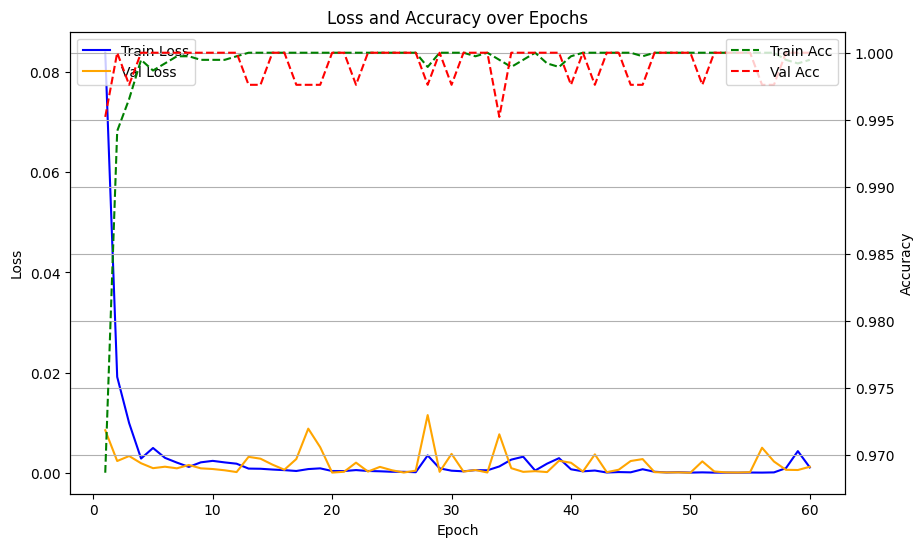

Inference: 100%|█████████████████████████████████████████████████████████████████████| 999/999 [01:13<00:00, 13.55it/s]


Saved predictions to validation_results.csv


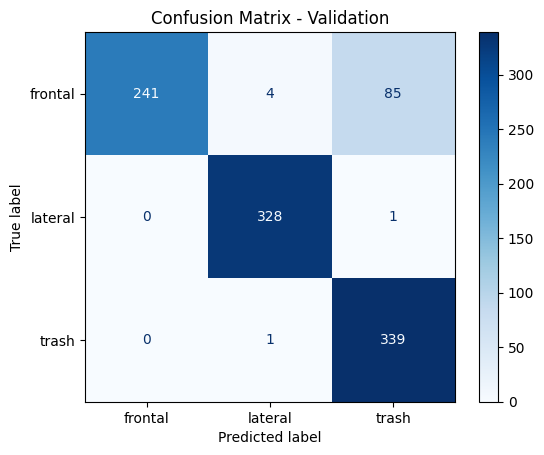

In [4]:
if __name__ == "__main__":
    train_model()
    infer()
